In [1]:
import sys
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as md
import datetime as dt
import time
import statistics

In [2]:
mkfunc2 = lambda x, pos: "2/"+time.ctime(x+9*3600)[8:16]
mkformatter2 = matplotlib.ticker.FuncFormatter(mkfunc2)

In [3]:
#prp_node_models={}
#with open("prp_node_models.csv") as fd:
#    for line in fd.readlines():
#        larr.line.strip().split(",",1)
#        prp_node_models[larr[0].replace(".","-")]=larr[1]

In [4]:
with open("runtimes.csv","r") as fd: lines=fd.readlines()


In [5]:
def parse(lines, cpus=2, sstrs=["2"]):
    data={}
    for line in lines[1:]:
      larr=line.strip().split(",")
      #print(larr)
      if len(larr)!=9:
        continue

      found=False
      for sstr in sstrs:
        if larr[8].strip().startswith(sstr):
          found=True
      if not found:
        continue

      #if int(float(larr[1].strip()))!=cpus:
      #  continue
        
      narr=larr[6].strip().split(".")
      if len(narr)<4:
            continue # old style log entry, ignore
      #print(narr)
      a=narr[0] # app nam
      n=narr[1] # node name
      d=narr[-1] #domain
      k = larr[3].strip()
            
      if d=="com": # google
        k=k+ " gke"

        mp=a.find("manual")
        if mp>0:
            mn=a[mp+6:]
            if len(mn)>0:
                k=k+" " + mn[0] + "xslots"
                if mn[0]=="3" and n.find("pv100-")>0 and n.find("pv100-16")<0:
                    k=k+" (low cpus)"

        print(k)
      elif d=="io":
        k=k+ " prp"
        hp=n.find("haosu")
        #if (hp>0):
        #    k=k+" h"+n[hp+6:hp+8]+ " " + larr[4]

        if a.find("manual")>0:
            #print(a,n)
            k=k+" " + a.split("-")[3] + "xslots"

      else:
        #k=k+ " unknown"
        continue # old style, ignore
      val=int(larr[7])

      if k not in data:
        data[k]=[]
      data[k].append(val)
    return data


In [6]:
def get_means(data, maxv=3600):
    means={}
    medians={}
    throughput={}
    for k in data:
        multiplier=1
        midx=k.find("xslo")
        if midx>0:
            multiplier=int(k[midx-1])
        else:
            midx=k.find("xsha")
            if midx>0:
                multiplier=int(k[midx-1])
        els=[]
        for val in data[k]:
            if val<maxv: # strip out outliers
                els.append(val)
        means[k] = statistics.mean(els)
        medians[k] = statistics.median(els)
        throughput[k] = multiplier * 24*3600/means[k]
    return (means,medians,throughput)

In [7]:
def save(data,means,medians,throughput,fname):
    with open(fname,"w") as fd:
        fd.write("#GPU, mean, median, throughput\n")
        klist=list(data.keys())
        klist.sort()
        for k in klist:
            fd.write("#%s, %i, %i, %i\n"%(k,means[k],medians[k],throughput[k]))
        #fd.write("#GPU, walltime\n")
        #for k in klist:
        #    for val in data[k]:
        #        fd.write("%s, %i\n"%(k,val))

In [8]:
def hvals(data, minv=0, maxv=3600, bins=20):
    rtimes=set()
    for k in data:
        rtimes = rtimes.union(data[k])

    rmin=max( (min(rtimes),minv) )
    rmax=min( (max(rtimes),maxv) )+1
    dr=(rmax-rmin)/float(bins)
    del rtimes
    
    data_times=[]
    data_values={}
    for k in data:
        data_values[k] = []
    for i in range(bins):
        data_times.append(int(rmin+dr/2+dr*i))
        for k in data:
            data_values[k].append(0)
    for k in data:
        nels=len(data[k])
        for ival in data[k]:
            val = min(max(rmin,ival),rmax-1) 
            b=int((val-rmin)/dr)
            data_values[k][b]+=1.0/nels
    return (data_times, data_values)

In [9]:
data=parse(lines, 2,["2022-03"])
means,medians,throughput=get_means(data)
save(data,means,medians,throughput,"runtimes.o4.htc.csv")
rtimes,rvals=hvals(data,maxv=2200,bins=20)

A100-SXM4-40GB gke
A100-SXM4-40GB gke
A100-SXM4-40GB gke
A100-SXM4-40GB gke
A100-SXM4-40GB gke
A100-SXM4-40GB gke
A100-SXM4-40GB gke
A100-SXM4-40GB gke
A100-SXM4-40GB gke
A100-SXM4-40GB gke
A100-SXM4-40GB gke
A100-SXM4-40GB gke
A100-SXM4-40GB gke
A100-SXM4-40GB gke
A100-SXM4-40GB gke
A100-SXM4-40GB gke
A100-SXM4-40GB gke 3xslots
A100-SXM4-40GB gke 3xslots
A100-SXM4-40GB gke 3xslots
A100-SXM4-40GB gke
A100-SXM4-40GB gke
A100-SXM4-40GB gke
A100-SXM4-40GB gke
A100-SXM4-40GB gke 7xslots
A100-SXM4-40GB gke
A100-SXM4-40GB gke 7xslots
A100-SXM4-40GB gke
A100-SXM4-40GB gke
A100-SXM4-40GB gke
A100-SXM4-40GB gke
A100-SXM4-40GB gke
A100-SXM4-40GB gke
A100-SXM4-40GB gke
A100-SXM4-40GB gke 3xslots
A100-SXM4-40GB gke 3xslots
Tesla V100-SXM2-16GB gke 3xslots (low cpus)
Tesla V100-SXM2-16GB gke 3xslots (low cpus)
A100-SXM4-40GB gke
A100-SXM4-40GB gke
A100-SXM4-40GB gke
A100-SXM4-40GB gke
A100-SXM4-40GB gke 3xslots
A100-SXM4-40GB gke
A100-SXM4-40GB gke
A100-SXM4-40GB gke
A100-SXM4-40GB gke 3xslots
A100

In [10]:
#print(data.keys())
#print(rtimes)
#print(rvals)

  150   901   900    95 A100-SXM4-40GB gke
  173   784   792   220 A100-SXM4-40GB gke 2xslots
   22   893   882   290 A100-SXM4-40GB gke 3xslots
  229  1338  1332   451 A100-SXM4-40GB gke 7xslots


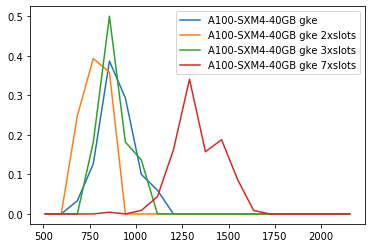

In [11]:
rkeys=list(rvals.keys())
rkeys.sort()
for k in rkeys:
    if k.find("A100")<0:
        continue
    plt.plot(rtimes, rvals[k], label=k)
    print("%5i %5i %5i %5i %s"%(len(data[k]),means[k],medians[k],throughput[k],k))
plt.legend(loc=1)
plt.show()

  150   901   900    95 A100-SXM4-40GB gke
  173   784   792   220 A100-SXM4-40GB gke 2xslots
   22   893   882   290 A100-SXM4-40GB gke 3xslots
  229  1338  1332   451 A100-SXM4-40GB gke 7xslots


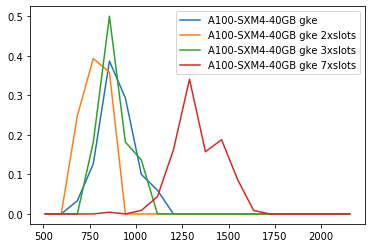

In [12]:
rkeys=list(rvals.keys())
rkeys.sort()
for k in rkeys:
    if k.find("A100")<0:
        continue
    if k.find("prp")>=0:
        continue
    if k.find("MIG")>=0:
        continue


    plt.plot(rtimes, rvals[k], label=k)
    print("%5i %5i %5i %5i %s"%(len(data[k]),means[k],medians[k],throughput[k],k))
plt.legend(loc=1)
plt.savefig("o4_htc_a100shr.png", format="png")
plt.savefig("o4_htc_a100shr.svg", format="svg")
plt.show()

  775   547   540   157 NVIDIA A40 prp
  181   690   684   250 NVIDIA A40 prp 2xslots
  288   854   864   404 NVIDIA A40 prp 4xslots
   56  1676  1728   412 NVIDIA A40 prp 8xslots


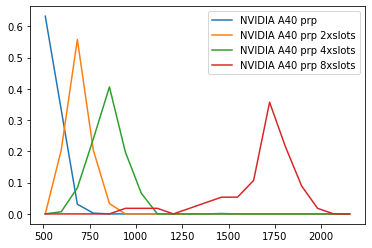

In [13]:
rkeys=list(rvals.keys())
rkeys.sort()
for k in rkeys:
    if k.find("A40")<0:
        continue


    plt.plot(rtimes, rvals[k], label=k)
    print("%5i %5i %5i %5i %s"%(len(data[k]),means[k],medians[k],throughput[k],k))
plt.legend(loc=1)
plt.savefig("o4_htc_a40shr.png", format="png")
plt.savefig("o4_htc_a40shr.svg", format="svg")
plt.show()

   98   879   864    98 Tesla V100-SXM2-16GB gke
   85  1171  1152   147 Tesla V100-SXM2-16GB gke 2xslots
  301  1341  1332   193 Tesla V100-SXM2-16GB gke 3xslots
  212  1712  1692   151 Tesla V100-SXM2-16GB gke 3xslots (low cpus)


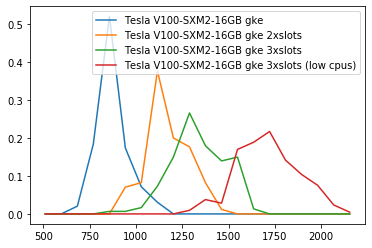

In [14]:
rkeys=list(rvals.keys())
rkeys.sort()
for k in rkeys:
    if not k.startswith("Tesla V"):
        continue
    if k.find("prp")>=0:
        continue

    plt.plot(rtimes, rvals[k], label=k)
    print("%5i %5i %5i %5i %s"%(len(data[k]),means[k],medians[k],throughput[k],k))
plt.legend(loc=1)
plt.savefig("o4_htc_v100gshr.png", format="png")
plt.savefig("o4_htc_v100gshr.svg", format="svg")
plt.show()

  241   612   612   141 Tesla V100-SXM2-32GB prp
   72  1232  1188   210 Tesla V100-SXM2-32GB prp 3xslots
   67  1664  1728   207 Tesla V100-SXM2-32GB prp 4xslots


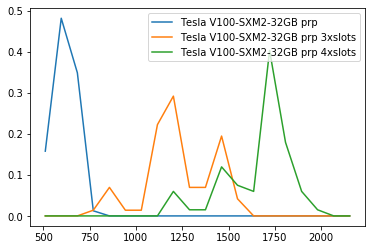

In [15]:
rkeys=list(rvals.keys())
rkeys.sort()
for k in rkeys:
    if not k.startswith("Tesla V"):
        continue
    if k.find("prp")<0:
        continue

    plt.plot(rtimes, rvals[k], label=k)
    print("%5i %5i %5i %5i %s"%(len(data[k]),means[k],medians[k],throughput[k],k))
plt.legend(loc=1)
plt.savefig("o4_htc_v100pshr.png", format="png")
plt.savefig("o4_htc_v100pshr.svg", format="svg")
plt.show()

  353   865   864    99 Tesla T4 gke
  102  1306  1296   132 Tesla T4 gke 2xslots


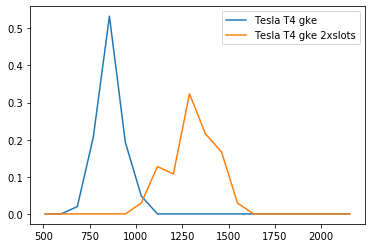

In [16]:
rkeys=list(rvals.keys())
rkeys.sort()
for k in rkeys:
    if not k.startswith("Tesla T"):
        continue
    if k.find("prp")>=0:
        continue

    plt.plot(rtimes, rvals[k], label=k)
    print("%5i %5i %5i %5i %s"%(len(data[k]),means[k],medians[k],throughput[k],k))
plt.legend(loc=1)
plt.savefig("o4_htc_t4shr.png", format="png")
plt.savefig("o4_htc_t4shr.svg", format="svg")
plt.show()

  431   743   720   116 NVIDIA GeForce RTX 2080 Ti prp
  212  1226  1188   140 NVIDIA GeForce RTX 2080 Ti prp 2xslots


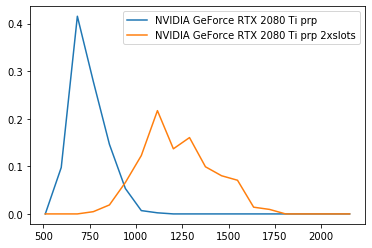

In [17]:
rkeys=list(rvals.keys())
rkeys.sort()
for k in rkeys:
    if not k.startswith("NVIDIA GeForce RTX 2080 Ti"):
        continue

    plt.plot(rtimes, rvals[k], label=k)
    print("%5i %5i %5i %5i %s"%(len(data[k]),means[k],medians[k],throughput[k],k))
plt.legend(loc=1)
plt.savefig("o4_htc_2080shr.png", format="png")
plt.savefig("o4_htc_2080shr.svg", format="svg")
plt.show()

   94   648   648   133 NVIDIA GeForce RTX 3090 prp
  216   616   612   280 NVIDIA GeForce RTX 3090 prp 2xslots
  291   852   864   405 NVIDIA GeForce RTX 3090 prp 4xslots


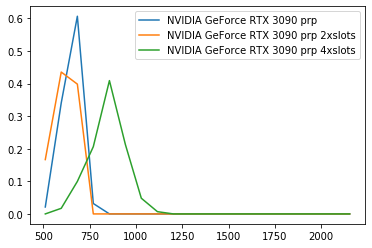

In [18]:
rkeys=list(rvals.keys())
rkeys.sort()
for k in rkeys:
    if not k.startswith("NVIDIA GeForce RTX 3090"):
        continue

    plt.plot(rtimes, rvals[k], label=k)
    print("%5i %5i %5i %5i %s"%(len(data[k]),means[k],medians[k],throughput[k],k))
plt.legend(loc=1)
plt.savefig("o4_htc_3090shr.png", format="png")
plt.savefig("o4_htc_3090shr.svg", format="svg")
plt.show()

In [19]:
#data=parse(lines,2,"2022-03")
#means,medians=get_means(data)
#rtimes,rvals=hvals(data,bins=20)
#save(data,means,medians,"runtimes.prp_c2.csv")

In [20]:
#data=parse(lines, 2,["2022-03"])
#means,medians,throughput=get_means(data)
#rtimes,rvals=hvals(data,maxv=3600,bins=30)

  150   901   900    95 A100-SXM4-40GB gke
  173   784   792   220 A100-SXM4-40GB gke 2xslots
   22   893   882   290 A100-SXM4-40GB gke 3xslots
  229  1338  1332   451 A100-SXM4-40GB gke 7xslots
  775   547   540   157 NVIDIA A40 prp
  181   690   684   250 NVIDIA A40 prp 2xslots
  288   854   864   404 NVIDIA A40 prp 4xslots
   56  1676  1728   412 NVIDIA A40 prp 8xslots
  431   743   720   116 NVIDIA GeForce RTX 2080 Ti prp
  212  1226  1188   140 NVIDIA GeForce RTX 2080 Ti prp 2xslots
   94   648   648   133 NVIDIA GeForce RTX 3090 prp
  216   616   612   280 NVIDIA GeForce RTX 3090 prp 2xslots
  291   852   864   405 NVIDIA GeForce RTX 3090 prp 4xslots
  353   865   864    99 Tesla T4 gke
  102  1306  1296   132 Tesla T4 gke 2xslots
   98   879   864    98 Tesla V100-SXM2-16GB gke
   85  1171  1152   147 Tesla V100-SXM2-16GB gke 2xslots
  301  1341  1332   193 Tesla V100-SXM2-16GB gke 3xslots
  212  1712  1692   151 Tesla V100-SXM2-16GB gke 3xslots (low cpus)
  241   612   612   1

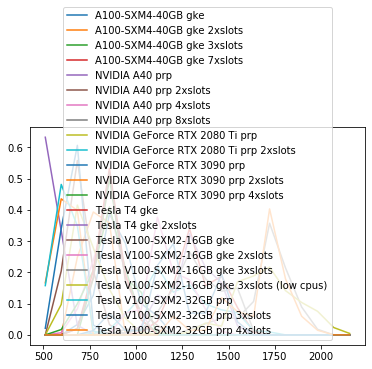

In [21]:
rkeys=list(rvals.keys())
rkeys.sort()
for k in rkeys:
    #if k.endswith("are"):
    #    continue
    plt.plot(rtimes, rvals[k], label=k)
    print("%5i %5i %5i %5i %s"%(len(data[k]),means[k],medians[k],throughput[k],k))
plt.legend()
plt.show()

  775   547   540   157 NVIDIA A40 prp
  181   690   684   250 NVIDIA A40 prp 2xslots
  288   854   864   404 NVIDIA A40 prp 4xslots
   56  1676  1728   412 NVIDIA A40 prp 8xslots
  431   743   720   116 NVIDIA GeForce RTX 2080 Ti prp
  212  1226  1188   140 NVIDIA GeForce RTX 2080 Ti prp 2xslots
   94   648   648   133 NVIDIA GeForce RTX 3090 prp
  216   616   612   280 NVIDIA GeForce RTX 3090 prp 2xslots
  291   852   864   405 NVIDIA GeForce RTX 3090 prp 4xslots


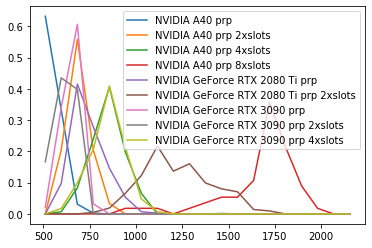

In [22]:
rkeys=list(rvals.keys())
rkeys.sort()
for k in rkeys:
    if k.find("100")>0 or k.find("T4")>0:
        continue
    plt.plot(rtimes, rvals[k], label=k)
    print("%5i %5i %5i %5i %s"%(len(data[k]),means[k],medians[k],throughput[k],k))
plt.legend()
plt.show()